<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/jobs_causality/jobs_rct_causalml_xlearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install causalml

     |████████████████████████████████| 3.9MB 4.9MB/s 
     |████████████████████████████████| 276kB 37.4MB/s 
     |████████████████████████████████| 1.8MB 39.6MB/s 
  Created wheel for causalml: filename=causalml-0.8.0-cp36-cp36m-linux_x86_64.whl size=482039 sha256=d3fba7e882b358aa3aca9a2695a3564d3e92136da4cafb97dea6fd1c24844fcf
  Stored in directory: /root/.cache/pip/wheels/db/d8/1f/c5c57e0a0a1e2d597da3b4b73f26a0365874e363bb1b57db41
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=517324d3770ef8b7147f9f015abd27ab429f3ea17bd6a7e93a7e084eaea37949
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
%cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/jobs_causality
%ls

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/jobs_causality
dataset/  jobs_causalml_xlearner.ipynb


# 職業訓練データセットでCausalmlの練習

In [95]:
import os

import numpy as np
import pandas as pd

from causalml.inference.meta import BaseXRegressor
from causalml.metrics import get_tmlegain, plot_tmlegain, plot_tmleqini, Sensitivity
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

## 職業訓練データセット読み込み
**職業訓練を受けた人は、収入がどのくらい増加/減少するのか因果分析**<br>
職業訓練データセットの詳細について：[https://users.nber.org/~rdehejia/data/.nswdata2.html](https://users.nber.org/~rdehejia/data/.nswdata2.html)

Dataset description
* treat: 1 if the subject participated in the job  training program, 0 otherwise
* age: the subject's age
* educ: years of education
* race: categorical variable with three possible values: Black, Hispanic, or White
* married: 1 if the subject was married at the time of the training program, 0 otherwise
* nodegree: 1 if the subject has earned no school degree, 0 otherwise
* re74: real earnings in 1974 (pre-treatment)
* re75: real earnings in 1975 (pre-treatment)
* re78: real earnings in 1978 (outcome)

In [96]:
stan_path='dataset/nsw.dta' # Lalonde Sample 
#stan_path='dataset/nsw_dw.dta' # Dehejia-Wahha Sample
df = pd.read_stata(stan_path)

OUTCOME_COLUMN = 're78'
TREATMENT_COLUMN = 'treat'
UNNECESSARY_COLUMNS = ['data_id']
FEATURE_COLUMNS = list(df.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]+UNNECESSARY_COLUMNS).columns)

print('outcome:{col}'.format(col=OUTCOME_COLUMN))
print('treatment:{col}'.format(col=TREATMENT_COLUMN))
print('features:{cols}'.format(cols=FEATURE_COLUMNS))

df['treat'] = df['treat'].astype(int)
df.head()

outcome:re78
treatment:treat
features:['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75']


,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.045898
1,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.894043
2,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.449219
3,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.145996
4,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.789886


In [97]:
df.describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,0.411357,24.520776,10.267313,0.800554,0.105263,0.162050,0.779778,3042.896240,5454.638672
std,0.492421,6.625947,1.704774,0.399861,0.307105,0.368752,0.414683,5066.138672,6252.948242
min,0.000000,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,936.307953,3951.889038
75%,1.000000,27.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3993.206970,8772.004395
max,1.000000,55.000000,16.000000,1.000000,1.000000,1.000000,1.000000,37431.660156,60307.929688


### 単純な平均値の比較

In [98]:
control_group = df.query(TREATMENT_COLUMN + '==0')[OUTCOME_COLUMN].mean()
treatment_group = df.query(TREATMENT_COLUMN + '==1')[OUTCOME_COLUMN].mean()
print('介入群のアウトカムの平均値:{}'.format(control_group))
print('コントロール群のアウトカムの平均値:{}'.format(treatment_group))
print('単純な平均値の差:{}'.format(treatment_group-control_group))

介入群のアウトカムの平均値:5090.0478515625
コントロール群のアウトカムの平均値:5976.353515625
単純な平均値の差:886.3056640625


今回求めた推定量を$\hat{\tau}_{naive}$と置くと
$$\hat{\tau}_{naive} = E[Y^{(1)}|t=1]-E[Y^{(0)}|t=0]$$
$$=E[Y^{(1)}-Y^{(0)}]+E[Y^{(0)}|t=1]-E[Y^{(0)}|t=0]$$
セレクションバイアスが生じているため、**単純な平均値の差の比較**では望ましくない因果効果の算出方法であることが分かる。<br>
<font color="Red">（今回のデータセットについては、介入が無作為で割り当てらているためセレクションバイアスはほぼ無いと考えられる）</font>

In [99]:
SEED = 2

data = df.drop(columns=UNNECESSARY_COLUMNS)

train_X, test_X, train_y, test_y = train_test_split(data.drop(columns=OUTCOME_COLUMN).values, data[OUTCOME_COLUMN].values,
                                                    test_size=0.2, random_state=SEED)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=0.2, random_state=SEED)
# t:treatment(介入変数)の取り出し
train_t = train_X[:,0].astype(int)
train_X = train_X[:,1:]
val_t = val_X[:,0].astype(int)
val_X = val_X[:,1:]
test_t = test_X[:,0].astype(int)
test_X = test_X[:,1:]

print('data.shape:{}'.format(data.shape))
print('train_X:{}, train_t:{}, train_y:{}'.format(train_X.shape, train_t.shape, train_y.shape))
print('val_X:{}, val_t:{}, val_y:{}'.format(val_X.shape, val_t.shape, val_y.shape))
print(('test_X:{}, test_t:{}, test_y:{}'.format(test_X.shape, test_t.shape, test_y.shape)))

data.shape:(722, 9)
train_X:(461, 7), train_t:(461,), train_y:(461,)
val_X:(116, 7), val_t:(116,), val_y:(116,)
test_X:(145, 7), test_t:(145,), test_y:(145,)


## 傾向スコアモデル作成

In [100]:
# causalmlで使用できるElasticNetPropensityModelでは内部でsklearn.linear_model.ElasticNetCVが使われている
# ElasticNetPropensityModelでは検証用データを使えなさそうなので、過学習を防ぐためにも今回はxgboostを使用
# ps：propensity score(傾向スコア)
ps_model = XGBClassifier(n_estimators=1000,random_state=SEED)
# 目的変数をTreatmentとして学習
ps_model.fit(X=train_X, y=train_t, eval_set=[(val_X, val_t)],
             early_stopping_rounds=5)

# 傾向スコア算出
train_ps = ps_model.predict_proba(data=train_X)[:,1]
val_ps = ps_model.predict_proba(data=val_X)[:,1]
print('train_ps:{}, val_ps:{}'.format(train_ps.shape, val_ps.shape))
print('train_ps[:5]:{}'.format(train_ps[:5]))

[0]	validation_0-error:0.431034
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.37069
[2]	validation_0-error:0.37069
[3]	validation_0-error:0.37069
[4]	validation_0-error:0.37069
[5]	validation_0-error:0.37069
[6]	validation_0-error:0.37069
Stopping. Best iteration:
[1]	validation_0-error:0.37069

train_ps:(461,), val_ps:(116,)
train_ps[:5]:[0.43394563 0.48648664 0.4962392  0.48648664 0.48648664]


In [101]:
test_ps_score = ps_model.score(X=test_X, y=test_t)
print('テストデータに対する傾向スコアモデルの精度:{score}'.format(score=test_ps_score))

テストデータに対する傾向スコアモデルの精度:0.6137931034482759


## MetaLearnerモデル作成

In [102]:
# 観測されたアウトカムから反事実を予測するMetaLearnerモデルを構築していく
# 一般的なMLの学習タスクと異なり、正解に反事実が含まれるためmae,val_loss等を算出できない
# 今回は、傾向スコアモデル学習時と異なり、学習データを少しでも水増しさせるため検証データを加える
learner_train_X = np.concatenate([train_X, val_X])
learner_train_t = np.concatenate([train_t, val_t])
learner_train_y = np.concatenate([train_y, val_y])
learner_train_ps = np.concatenate([train_ps, val_ps])
print('learner_train_ps:{}'.format(learner_train_ps.shape))

learner_train_ps:(577,)


In [103]:
%%time
x_learner = BaseXRegressor(XGBRegressor(n_estimators=1000,random_state=SEED))

x_learner.fit(X=learner_train_X, treatment=learner_train_t, 
              y=learner_train_y, p=learner_train_ps)

[14:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 671 ms, sys: 24.2 ms, total: 696 ms
Wall time: 701 ms


## 予測結果の確認


In [104]:
# 解析対象となるデータ用意(学習/検証/テストデータの結合)
learner_input_X = np.concatenate([train_X, val_X, test_X])
learner_input_t = np.concatenate([train_t, val_t, test_t])
learner_input_y = np.concatenate([train_y, val_y, test_y])

test_ps = ps_model.predict_proba(test_X)[:,1]
learner_input_ps = np.concatenate([train_ps, val_ps, test_ps])
print('learner_input_ps:{}'.format(learner_input_ps.shape))

learner_input_ps:(722,)


### ATE:AverageTreatmentEffect（平均因果効果）

In [105]:
%%time
ate = x_learner.estimate_ate(X=learner_input_X, treatment=learner_input_t,
                             y=learner_input_y, p=learner_input_ps)

[14:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 851 ms, sys: 29.6 ms, total: 880 ms
Wall time: 882 ms


In [106]:
# ATE:AverageTreatmentEffect
print('ATE:{ate}'.format(ate=ate[0][0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=ate[1][0]))
print('信頼区間の上限値(UB):{ub}'.format(ub=ate[2][0]))

ATE:882.7977300628071
信頼区間の下限値(LB):310.3630819961652
信頼区間の上限値(UB):1455.232378129449


### ITE:IndividualTreatmentEffect（個別的因果効果）

In [107]:
%%time
ite = x_learner.predict(X=learner_input_X, treatment=learner_input_t,
                        y=learner_input_y, p=learner_input_ps)

CPU times: user 65.7 ms, sys: 0 ns, total: 65.7 ms
Wall time: 66.2 ms


In [108]:
# ITE:IndividualTreatmentEffect
insert_column = 'ITE'

if insert_column in df.columns:
  df.drop(columns=insert_column,inplace=True)
df.insert(loc=0, column=insert_column, value=ite)
df

,ITE,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,-7674.987305,Lalonde Sample,1,37,11,1,0,1,1,0.000000,9930.045898
1,-2245.755127,Lalonde Sample,1,22,9,0,1,0,1,0.000000,3595.894043
2,4774.103516,Lalonde Sample,1,30,12,1,0,0,0,0.000000,24909.449219
3,3454.171875,Lalonde Sample,1,27,11,1,0,0,1,0.000000,7506.145996
4,-16805.341797,Lalonde Sample,1,33,8,1,0,0,1,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...,...
717,-2382.829590,Lalonde Sample,0,20,10,1,0,0,1,825.230103,0.000000
718,20265.615234,Lalonde Sample,0,17,9,0,1,0,1,0.000000,5114.813965
719,10576.161133,Lalonde Sample,0,17,9,1,0,0,1,1206.441040,0.000000
720,-4837.734375,Lalonde Sample,0,19,11,1,0,0,1,0.000000,0.000000


### 特徴量毎の重要度の確認

[14:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


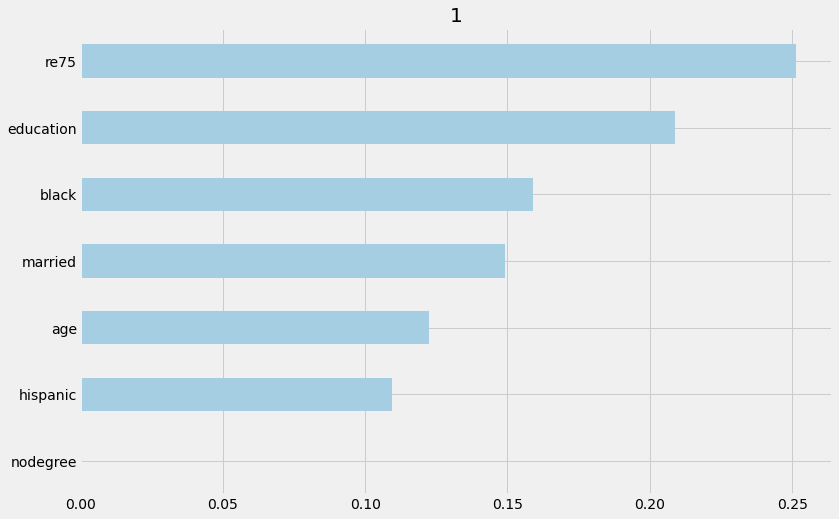

In [109]:
x_learner.plot_importance(X=learner_input_X,
                          tau=ite,
                          model_tau_feature=XGBRegressor(random_state=SEED),
                          features=FEATURE_COLUMNS,
                          method='auto',
                          random_state=SEED)

### 特徴量毎のshap値確認

[14:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


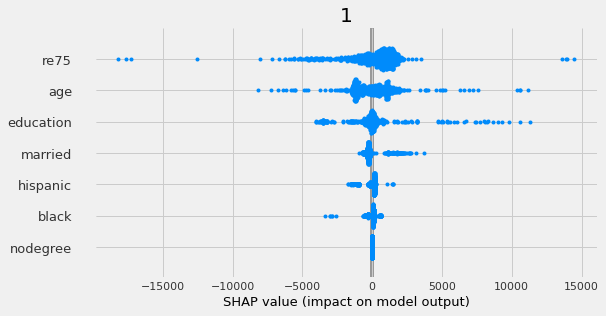

In [110]:
x_learner.plot_shap_values(X=learner_input_X, tau=ite, 
                           features=FEATURE_COLUMNS,
                           model_tau_feature=XGBRegressor(random_state=SEED))

## モデルの評価
TMLE:Targeted maximum likelihood estimation(局所的に最尤推定を行う)モデルとの比較。<br>正解となる目的変数にはCounterfactual(反事実)が含まれているため、一般的な精度が算出できない。そこでTMLEモデルをベースラインにして、構築したモデルの精度を比較し評価する。

In [111]:
# 傾向スコアの挿入
PS_COLUMN = 'ps'
insert_column = PS_COLUMN

if insert_column in df.columns:
  df.drop(columns=insert_column,inplace=True)
df.insert(loc=0, column=insert_column, value=learner_input_ps)
df.head()

,ps,ITE,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,0.433946,-7674.987305,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.045898
1,0.486487,-2245.755127,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.894043
2,0.496239,4774.103516,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.449219
3,0.486487,3454.171875,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.145996
4,0.486487,-16805.341797,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.789886


In [112]:
tmlgeain = get_tmlegain(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
                                    learner=XGBRegressor(n_estimators=1000, random_state=SEED),
                                    outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,ci=True)
tmlgeain

[14:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,ITE,ITE LB,ITE UB,Random
0.0,0.000000,0.000000,0.000000,0.000000
0.2,242.062984,49.002707,435.123261,122.406853
0.4,388.483032,-21.045297,798.011361,244.813706
0.6,380.281532,-279.031135,1039.594199,367.220558
0.8,363.958366,-490.773487,1218.690219,489.627411
1.0,612.034264,134.181500,1089.887028,612.034264


[14:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


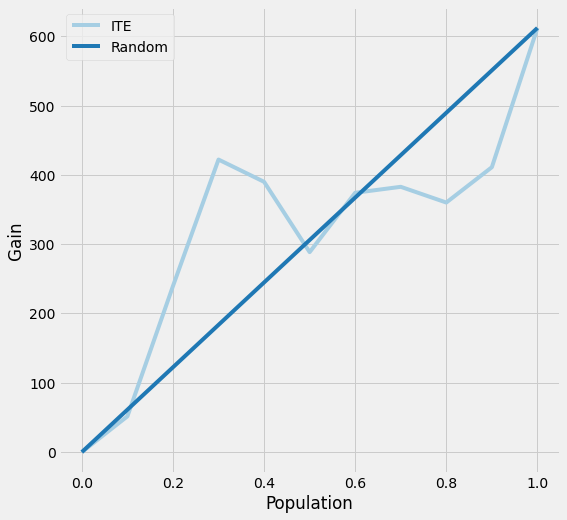

In [113]:
plot_tmlegain(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

そんなに綺麗なupliftカーブを描いてくれない、、、そんなに精度よく無さそう<br>
[公式チュートリアル:https://github.com/uber/causalml/blob/master/examples/validation_with_tmle.ipynb](https://github.com/uber/causalml/blob/master/examples/validation_with_tmle.ipynb)

[14:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


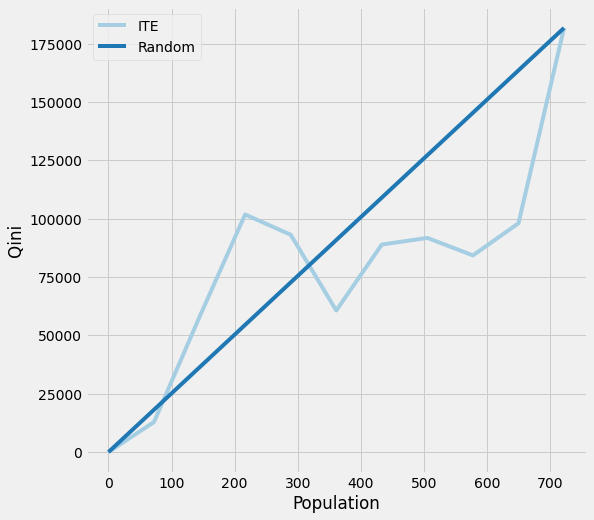

In [114]:
plot_tmleqini(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

## 感度分析
元のデータを一部変化させることで、推定された因果効果のロバスト性を確認する分析手法<br>
causalmlドキュメントに挙げられている感度分析の種類
* Placebo Treatment
* Irrelevant Additional Confounder
* Subset validation
* Random Replace
* Selection Bias


In [115]:
df.head()

,ps,ITE,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,0.433946,-7674.987305,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.045898
1,0.486487,-2245.755127,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.894043
2,0.496239,4774.103516,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.449219
3,0.486487,3454.171875,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.145996
4,0.486487,-16805.341797,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.789886


In [116]:
# Sensitivityクラスのインスタンス化
sensitivity = Sensitivity(df=df.drop(columns=[','.join(UNNECESSARY_COLUMNS) , 'ITE']),
                          inference_features=FEATURE_COLUMNS,
                          p_col=PS_COLUMN, treatment_col=TREATMENT_COLUMN,
                          outcome_col=OUTCOME_COLUMN, learner=x_learner)
# ATEの再確認
s_ate_ci = sensitivity.get_ate_ci(X=learner_input_X, p=learner_input_ps,
                                  treatment=learner_input_t, y=learner_input_y)
print('ATE:{ate}'.format(ate=s_ate_ci[0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=s_ate_ci[1]))
print('信頼区間の上限値(UB):{ub}'.format(ub=s_ate_ci[2]))

[14:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ATE:882.7977300628071
信頼区間の下限値(LB):310.3630819961652
信頼区間の上限値(UB):1455.232378129449


In [117]:
# causalmlで使用可能な感度分析一覧
sensitivity_methods = ['Placebo Treatment', 'Random Cause',
                      'Subset Data', 'Random Replace', 
                      'Selection Bias']
sensitivity_methods

['Placebo Treatment',
 'Random Cause',
 'Subset Data',
 'Random Replace',
 'Selection Bias']

confound引数に渡せる関数一覧
* one_sided
* alignment
* one_sided_att
* alignment_att<br>
[詳細：https://www.mattblackwell.org/files/papers/causalsens.pdf](https://www.mattblackwell.org/files/papers/causalsens.pdf)

### sample_size=0.2

In [118]:
%%time
sensitivity_result = sensitivity.sensitivity_analysis(methods=sensitivity_methods,
                                             sample_size=0.2, confound='alignment')

[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [119]:
pd.options.display.max_colwidth = 100
sensitivity_result

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,885.045,573.84,43.7381,1103.94
0,Random Cause,885.045,591.866,159.539,1024.19
0,Subset Data(sample size @0.2),885.045,720.237,-675.223,2115.7
0,Random Replace,885.045,460.433,43.8803,876.986
0,"Selection Bias (alpha@-4386.0022, with r-sqaure:0.06845",885.045,969.377,402.259,1536.49
0,"Selection Bias (alpha@-3508.80176, with r-sqaure:0.04376",885.045,1003.06,439.609,1566.51
0,"Selection Bias (alpha@-2631.60132, with r-sqaure:0.02431",885.045,954.494,382.632,1526.36
0,"Selection Bias (alpha@-1754.40088, with r-sqaure:0.01108",885.045,958.742,393.443,1524.04
0,"Selection Bias (alpha@-877.20044, with r-sqaure:0.00272",885.045,982.191,410.372,1554.01
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",885.045,885.045,313.111,1456.98


### sample_size=0.5

In [120]:
%%time
sensitivity_result = sensitivity.sensitivity_analysis(methods=sensitivity_methods,
                                             sample_size=0.5, confound='alignment')

[14:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [121]:
pd.options.display.max_colwidth = 100
sensitivity_result

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,885.045,56.9952,-516.076,630.066
0,Random Cause,885.045,983.919,499.101,1468.74
0,Subset Data(sample size @0.5),885.045,483.443,-346.136,1313.02
0,Random Replace,885.045,1269.9,787.607,1752.2
0,"Selection Bias (alpha@-4386.0022, with r-sqaure:0.06845",885.045,969.377,402.259,1536.49
0,"Selection Bias (alpha@-3508.80176, with r-sqaure:0.04376",885.045,1003.06,439.609,1566.51
0,"Selection Bias (alpha@-2631.60132, with r-sqaure:0.02431",885.045,954.494,382.632,1526.36
0,"Selection Bias (alpha@-1754.40088, with r-sqaure:0.01108",885.045,958.742,393.443,1524.04
0,"Selection Bias (alpha@-877.20044, with r-sqaure:0.00272",885.045,982.191,410.372,1554.01
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",885.045,885.045,313.111,1456.98
